In [1]:
# Cell 0
import pandas as pd
import numpy as np
from pathlib import Path
import textwrap

# === Đường dẫn chỉnh lại theo máy của bạn ===
ROOT = Path("/home/kylh/phd/tw_fin_rl/work/data/gdelt_0024_hardfix_split/normalized_unique")
ARTICLES_PATH = ROOT / "articles.parquet"
REL_PATH      = ROOT / "article_token_map.parquet"

# Load
articles = pd.read_parquet(ARTICLES_PATH)
rel = pd.read_parquet(REL_PATH)

# Chuẩn kiểu thời gian
for c in ["first_seen","last_seen"]:
    if c in rel.columns:
        rel[c] = pd.to_datetime(rel[c], utc=True, errors="coerce")

for c in ["first_seen_any","last_seen_any","seendate"]:
    if c in articles.columns:
        articles[c] = pd.to_datetime(articles[c], utc=True, errors="coerce")

# Token list (toàn bộ)
ALL_TOKENS = sorted(rel["symbol_req"].dropna().unique().tolist())
ALL_TOKENS[:8], len(ALL_TOKENS)


(['BNB', 'BTC', 'ETH', 'SOL'], 4)

In [2]:
# Cell 1
def expand_days(rel_df: pd.DataFrame) -> pd.DataFrame:
    """
    Mở rộng days_list -> mỗi dòng là 1 ngày cụ thể cho 1 (url, token).
    Output: columns = [url_canon, symbol_req, day (datetime), first_seen, last_seen, n_hits]
    """
    tmp = rel_df.copy()
    # đảm bảo days_list là list
    tmp["days_list"] = tmp["days_list"].apply(lambda x: x if isinstance(x, (list, tuple, np.ndarray)) else [])
    tmp = tmp.explode("days_list", ignore_index=True)
    tmp = tmp.rename(columns={"days_list": "day"})
    tmp["day"] = pd.to_datetime(tmp["day"], format="%Y-%m-%d", errors="coerce")
    return tmp

def period_counts(df_days: pd.DataFrame, token: str):
    """
    Tạo phân bố theo ngày/tuần/tháng/năm cho 1 token.
    day_count: số URL unique theo ngày
    week_count: số URL unique theo tuần (ISO-week)
    month_count, year_count tương tự
    """
    tdf = df_days[df_days["symbol_req"] == token].copy()
    if tdf.empty:
        return (pd.DataFrame(), pd.DataFrame(), pd.DataFrame(), pd.DataFrame())

    # Đếm URL unique theo period
    day_count = (tdf.dropna(subset=["day"])
                    .groupby("day")["url_canon"]
                    .nunique()
                    .rename("n_urls")
                    .reset_index())

    # Tuần: dùng Mon-Sun ISO tuần (to_period("W-MON") để tuần bắt đầu T2)
    tdf["week"] = tdf["day"].dt.to_period("W-MON")  # tuần bắt đầu Monday
    week_count = (tdf.dropna(subset=["week"])
                    .groupby("week")["url_canon"]
                    .nunique()
                    .rename("n_urls")
                    .reset_index())
    week_count["week_start"] = week_count["week"].dt.start_time
    week_count["week_end"] = week_count["week"].dt.end_time

    # Tháng
    tdf["month"] = tdf["day"].dt.to_period("M")
    month_count = (tdf.dropna(subset=["month"])
                     .groupby("month")["url_canon"]
                     .nunique()
                     .rename("n_urls")
                     .reset_index())
    month_count["month_start"] = month_count["month"].dt.start_time
    month_count["month_end"] = month_count["month"].dt.end_time

    # Năm
    tdf["year"] = tdf["day"].dt.to_period("Y")
    year_count = (tdf.dropna(subset=["year"])
                    .groupby("year")["url_canon"]
                    .nunique()
                    .rename("n_urls")
                    .reset_index())
    year_count["year_start"] = year_count["year"].dt.start_time
    year_count["year_end"] = year_count["year"].dt.end_time

    return day_count, week_count, month_count, year_count

def token_basic_stats(rel_df: pd.DataFrame, token: str) -> dict:
    """
    In stats lõi cho 1 token: số URL unique, khoảng thời gian, tổng số hit (n_hits), top domain…
    """
    t = rel_df[rel_df["symbol_req"] == token].copy()
    if t.empty:
        return {"token": token, "n_urls": 0}

    n_urls = t["url_canon"].nunique()
    first_seen = t["first_seen"].min()
    last_seen  = t["last_seen"].max()
    total_hits = t["n_hits"].sum()
    median_hits = t["n_hits"].median()

    # Top 10 domain theo số URL unique
    # Join qua articles để lấy domain/title nếu cần
    dom = (t[["url_canon"]].drop_duplicates()
             .merge(articles[["url_canon","domain"]], on="url_canon", how="left"))
    top_domains = (dom.groupby("domain")["url_canon"].nunique()
                     .sort_values(ascending=False)
                     .head(10))

    return {
        "token": token,
        "n_urls": int(n_urls),
        "first_seen": first_seen,
        "last_seen": last_seen,
        "total_hits": int(total_hits),
        "median_hits_per_url": float(median_hits) if pd.notnull(median_hits) else None,
        "top_domains": top_domains
    }

def pretty_print_token_stats(stats: dict, max_domains: int = 10):
    print(f"=== {stats['token']} ===")
    print(f"- Unique URLs           : {stats['n_urls']:,}")
    print(f"- First seen (UTC)      : {stats.get('first_seen')}")
    print(f"- Last seen  (UTC)      : {stats.get('last_seen')}")
    print(f"- Total hits (sum)      : {stats.get('total_hits'):,}")
    print(f"- Median hits per URL   : {stats.get('median_hits_per_url')}")
    if "top_domains" in stats and isinstance(stats["top_domains"], pd.Series):
        print("- Top domains by unique URLs:")
        for dom, cnt in stats["top_domains"].head(max_domains).items():
            print(f"    {dom or '<NA>'}: {cnt}")
    print()


In [3]:
# Cell 2
rel_days = expand_days(rel)

# Ví dụ: chọn các token chính (theo bạn muốn)
TOKENS = ["BTC", "ETH", "BNB", "SOL"]

all_dists = {}
for tok in TOKENS:
    day_c, week_c, month_c, year_c = period_counts(rel_days, tok)
    all_dists[tok] = {
        "day": day_c,
        "week": week_c,
        "month": month_c,
        "year": year_c,
    }

# Stats cơ bản cho từng token
for tok in TOKENS:
    st = token_basic_stats(rel, tok)
    pretty_print_token_stats(st)


=== BTC ===
- Unique URLs           : 105,772
- First seen (UTC)      : 2020-08-11 00:15:00+00:00
- Last seen  (UTC)      : 2025-09-03 23:30:00+00:00
- Total hits (sum)      : 114,830
- Median hits per URL   : 1.0
- Top domains by unique URLs:
    biztoc.com: 11369
    forextv.com: 5804
    cointelegraph.com: 3367
    newsbtc.com: 3262
    benzinga.com: 2078
    fxstreet.com: 1961
    forbes.com: 1776
    insidebitcoins.com: 1705
    coindesk.com: 1700
    coinspeaker.com: 1625

=== ETH ===
- Unique URLs           : 25,927
- First seen (UTC)      : 2020-08-11 09:30:00+00:00
- Last seen  (UTC)      : 2025-09-03 19:15:00+00:00
- Total hits (sum)      : 29,695
- Median hits per URL   : 1.0
- Top domains by unique URLs:
    biztoc.com: 2618
    fxstreet.com: 1305
    newsbtc.com: 1039
    coinspeaker.com: 761
    benzinga.com: 706
    cointelegraph.com: 688
    fool.com: 509
    economictimes.indiatimes.com: 472
    invezz.com: 415
    insidebitcoins.com: 382

=== BNB ===
- Unique URLs    

In [4]:
# Cell 3
def token_news(articles_df: pd.DataFrame, rel_df: pd.DataFrame, token: str, limit: int = 20):
    """
    Trả về DataFrame gồm (url_canon, title, domain, first_seen, last_seen, n_hits)
    cho 1 token, sắp xếp theo last_seen (mới nhất ở trên).
    """
    t = rel_df[rel_df["symbol_req"] == token].copy()
    if t.empty:
        return pd.DataFrame(columns=["url_canon","title","domain","first_seen","last_seen","n_hits"])

    out = (t.merge(articles_df[["url_canon","title","domain","first_seen_any","last_seen_any"]],
                   on="url_canon", how="left")
             .rename(columns={"first_seen_any":"first_seen_any_url",
                              "last_seen_any":"last_seen_any_url"}))
    out = out.sort_values("last_seen", ascending=False)
    if limit is not None and limit > 0:
        out = out.head(limit)
    return out[["url_canon","title","domain","first_seen","last_seen","n_hits"]]

# Ví dụ: lấy 10 news mới nhất cho BTC
btc_latest10 = token_news(articles, rel, "BTC", limit=10)
btc_latest10.head(10)


,url_canon,title,domain,first_seen,last_seen,n_hits
5546,https://bitcoinmagazine.com/news/pierre-rochar...,Pierre Rochard To Headline Bitcoin For Financi...,bitcoinmagazine.com,2025-09-03 23:30:00+00:00,2025-09-03 23:30:00+00:00,1
58762,https://www.coindesk.com/markets/2025/09/03/so...,"Solana ( SOL ) Price News : Outperforms BTC , ...",coindesk.com,2025-09-03 23:00:00+00:00,2025-09-03 23:00:00+00:00,2
24713,https://finance.yahoo.com/news/michael-saylor-...,"Michael Saylor Strategy Scoops 4 , 048 BTC – $...",finance.yahoo.com,2025-09-03 23:00:00+00:00,2025-09-03 23:00:00+00:00,1
24914,https://finance.yahoo.com/news/strategy-buys-d...,"Strategy Buys the Dip , Stacks New 4 , 048 Bit...",finance.yahoo.com,2025-09-03 22:45:00+00:00,2025-09-03 22:45:00+00:00,1
89989,https://www.newsbtc.com/news/ethereum/ethereum...,Ethereum Network Activity Surges As Daily Tran...,newsbtc.com,2025-09-03 22:45:00+00:00,2025-09-03 22:45:00+00:00,1
69185,https://www.forbes.com/sites/kylemullins/2025/...,American Bitcoin Deal Boosts Eric Trump Net Worth,forbes.com,2025-09-03 22:00:00+00:00,2025-09-03 22:00:00+00:00,1
77615,https://www.journal-news.com/news/nation-world...,Trump - backed bitcoin company rises in first ...,journal-news.com,2025-09-03 21:45:00+00:00,2025-09-03 21:45:00+00:00,1
91242,https://www.nvdaily.com/associated_press_natio...,Trump - backed bitcoin company rises in first ...,nvdaily.com,2025-09-03 21:45:00+00:00,2025-09-03 21:45:00+00:00,1
96369,https://www.smh.com.au/business/markets/eric-t...,American Bitcoin debut : Eric Trump cashes in,smh.com.au,2025-09-03 21:00:00+00:00,2025-09-03 21:00:00+00:00,1
24908,https://finance.yahoo.com/news/strategy-added-...,"Strategy Added Another 4 , 408 Bitcoin for $45...",finance.yahoo.com,2025-09-03 21:00:00+00:00,2025-09-03 21:00:00+00:00,1


In [5]:
# Cell 4
def show_distribution_summary(dists: dict, token: str, head_n: int = 5):
    print(f"### Distribution for {token}")
    for k in ["day","week","month","year"]:
        dfk = dists[token][k]
        if dfk.empty:
            print(f"- {k}: <empty>")
            continue
        print(f"- {k}: {len(dfk)} rows | sample:")
        print(dfk.head(head_n))
    print()

for tok in TOKENS:
    show_distribution_summary(all_dists, tok, head_n=5)


### Distribution for BTC
- day: 1816 rows | sample:
         day  n_urls
0 2020-08-11      51
1 2020-08-12      58
2 2020-08-13      48
3 2020-08-14      53
4 2020-08-15      26
- week: 263 rows | sample:
                    week  n_urls week_start                      week_end
0  2020-08-11/2020-08-17     322 2020-08-11 2020-08-17 23:59:59.999999999
1  2020-08-18/2020-08-24     314 2020-08-18 2020-08-24 23:59:59.999999999
2  2020-08-25/2020-08-31     309 2020-08-25 2020-08-31 23:59:59.999999999
3  2020-09-01/2020-09-07     305 2020-09-01 2020-09-07 23:59:59.999999999
4  2020-09-08/2020-09-14     420 2020-09-08 2020-09-14 23:59:59.999999999
- month: 62 rows | sample:
     month  n_urls month_start                     month_end
0  2020-08     945  2020-08-01 2020-08-31 23:59:59.999999999
1  2020-09    1305  2020-09-01 2020-09-30 23:59:59.999999999
2  2020-10     967  2020-10-01 2020-10-31 23:59:59.999999999
3  2020-11    1596  2020-11-01 2020-11-30 23:59:59.999999999
4  2020-12    2299 

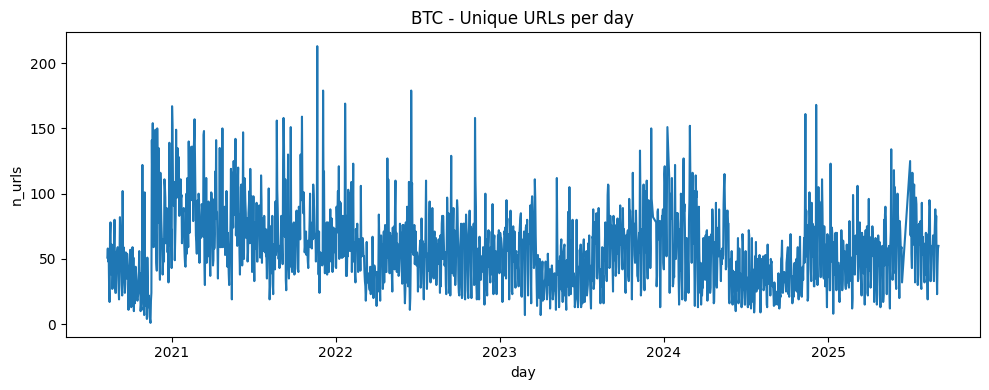

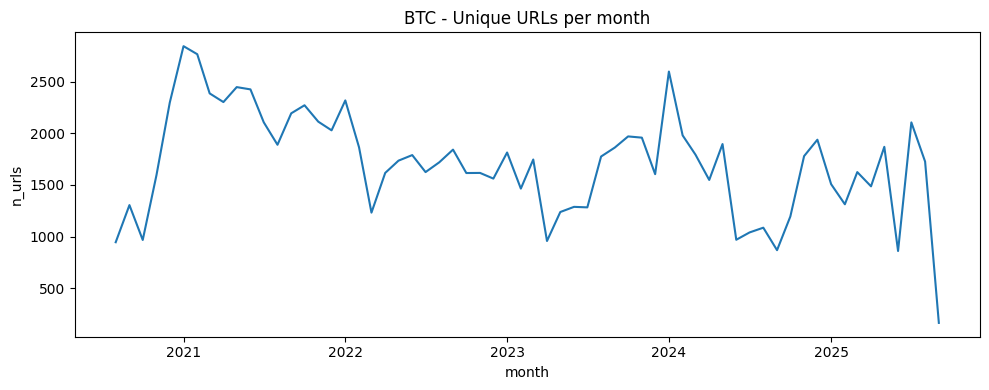

In [6]:
# Cell 5
import matplotlib.pyplot as plt

def plot_time_series(df, x_col, y_col, title):
    if df.empty:
        print(f"[skip] {title} (empty)")
        return
    # Vẽ đơn giản, không set color/style theo yêu cầu tối thiểu
    plt.figure(figsize=(10,4))
    plt.plot(df[x_col], df[y_col])
    plt.title(title)
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.tight_layout()
    plt.show()

# Ví dụ vẽ cho BTC: theo ngày và theo tháng
plot_time_series(all_dists["BTC"]["day"], "day", "n_urls", "BTC - Unique URLs per day")
plot_time_series(all_dists["BTC"]["month"][["month_start","n_urls"]].rename(columns={"month_start":"month"}),
                 "month", "n_urls", "BTC - Unique URLs per month")


/tmp/ipykernel_1697994/2489123110.py:12: DeprecationWarning: is_period_dtype is deprecated and will be removed in a future version. Use `isinstance(dtype, pd.PeriodDtype)` instead
  if is_period_dtype(x):


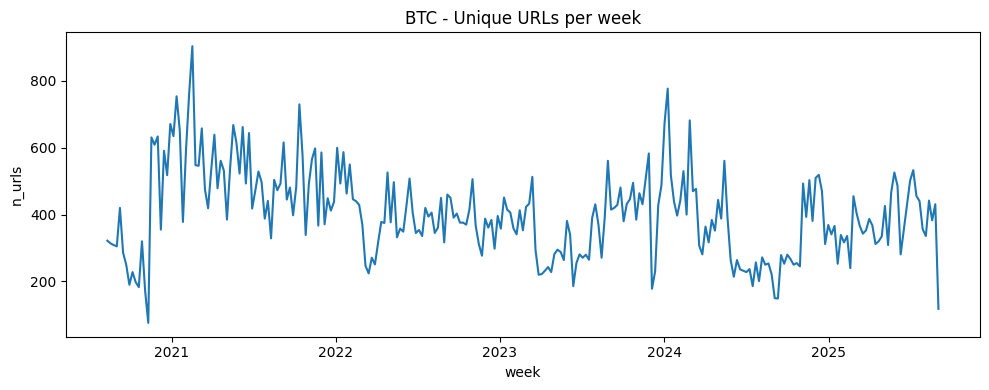

/tmp/ipykernel_1697994/2489123110.py:12: DeprecationWarning: is_period_dtype is deprecated and will be removed in a future version. Use `isinstance(dtype, pd.PeriodDtype)` instead
  if is_period_dtype(x):


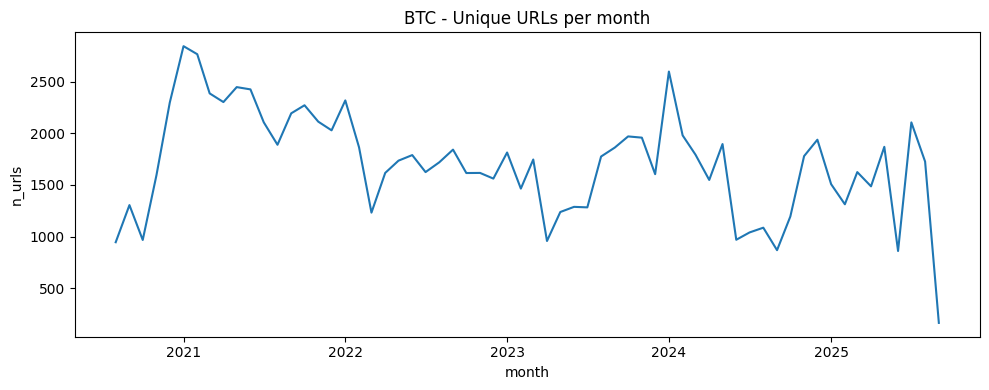

/tmp/ipykernel_1697994/2489123110.py:12: DeprecationWarning: is_period_dtype is deprecated and will be removed in a future version. Use `isinstance(dtype, pd.PeriodDtype)` instead
  if is_period_dtype(x):


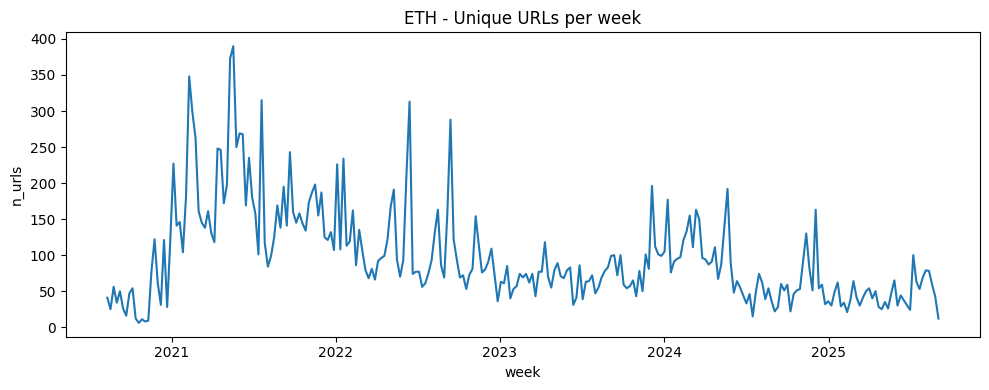

/tmp/ipykernel_1697994/2489123110.py:12: DeprecationWarning: is_period_dtype is deprecated and will be removed in a future version. Use `isinstance(dtype, pd.PeriodDtype)` instead
  if is_period_dtype(x):


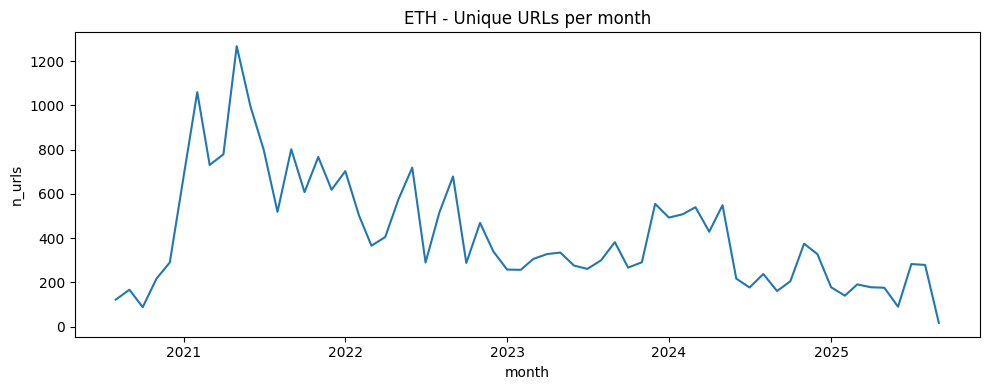

/tmp/ipykernel_1697994/2489123110.py:12: DeprecationWarning: is_period_dtype is deprecated and will be removed in a future version. Use `isinstance(dtype, pd.PeriodDtype)` instead
  if is_period_dtype(x):


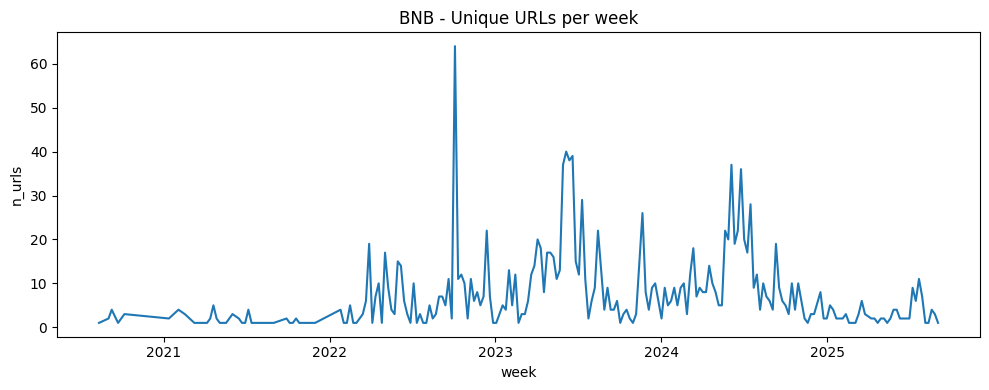

/tmp/ipykernel_1697994/2489123110.py:12: DeprecationWarning: is_period_dtype is deprecated and will be removed in a future version. Use `isinstance(dtype, pd.PeriodDtype)` instead
  if is_period_dtype(x):


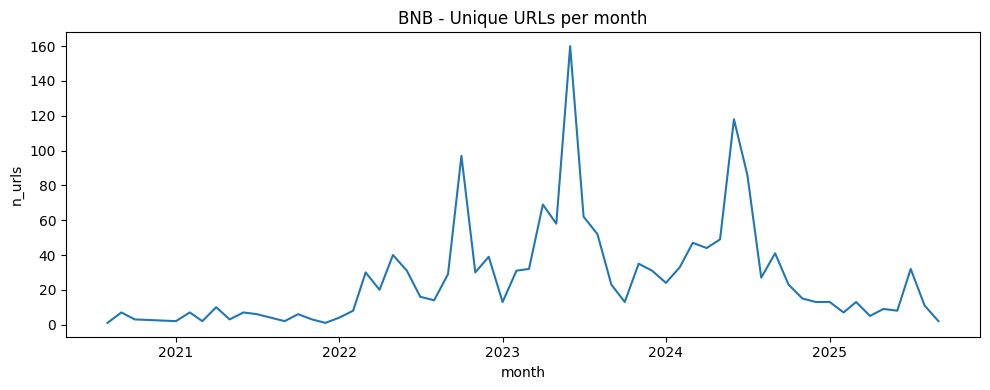

/tmp/ipykernel_1697994/2489123110.py:12: DeprecationWarning: is_period_dtype is deprecated and will be removed in a future version. Use `isinstance(dtype, pd.PeriodDtype)` instead
  if is_period_dtype(x):


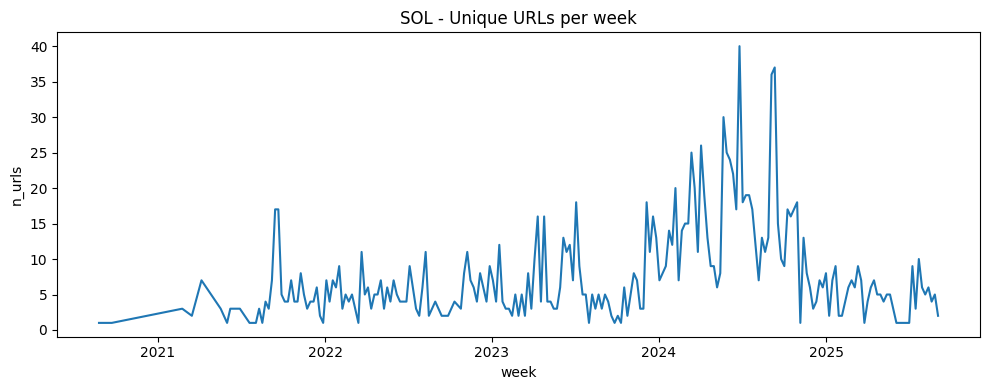

/tmp/ipykernel_1697994/2489123110.py:12: DeprecationWarning: is_period_dtype is deprecated and will be removed in a future version. Use `isinstance(dtype, pd.PeriodDtype)` instead
  if is_period_dtype(x):


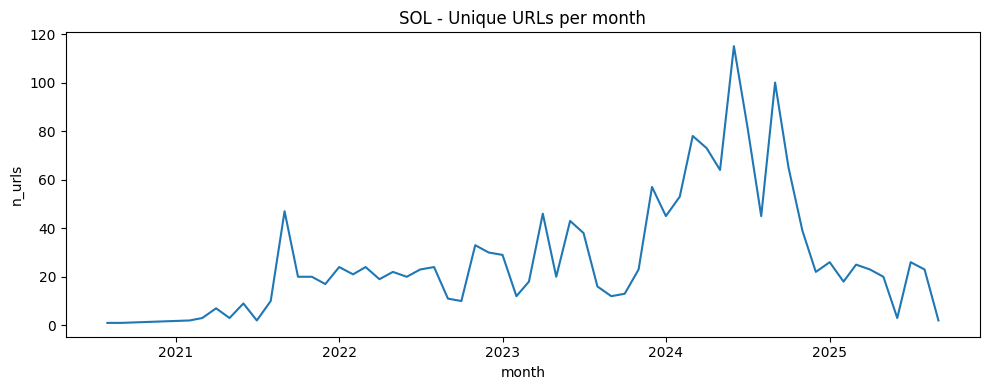

In [11]:
# Cell 5 (sửa hàm) - tự xử lý Period -> datetime
import matplotlib.pyplot as plt
from pandas.api.types import is_period_dtype, is_datetime64_any_dtype

def plot_time_series(df, x_col, y_col, title):
    if df.empty:
        print(f"[skip] {title} (empty)")
        return

    x = df[x_col]
    # Nếu là Period => lấy thời điểm bắt đầu kỳ
    if is_period_dtype(x):
        x = x.dt.start_time
    # Nếu là string ngày => convert datetime cho chắc
    if not is_datetime64_any_dtype(x):
        x = pd.to_datetime(x, errors="coerce")
    y = pd.to_numeric(df[y_col], errors="coerce")

    plt.figure(figsize=(10,4))
    plt.plot(x, y)
    plt.title(title)
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.tight_layout()
    plt.show()

# Cell 5c - gọi cho 4 token với đúng cột gốc (day/week/month/year)
TOKENS = ["BTC","ETH","BNB","SOL"]
for tok in TOKENS:
    # plot_time_series(all_dists[tok]["day"],   "day",   "n_urls", f"{tok} - Unique URLs per day")
    plot_time_series(all_dists[tok]["week"],  "week",  "n_urls", f"{tok} - Unique URLs per week")
    plot_time_series(all_dists[tok]["month"], "month", "n_urls", f"{tok} - Unique URLs per month")
    # plot_time_series(all_dists[tok]["year"],  "year",  "n_urls", f"{tok} - Unique URLs per year")


In [7]:
# Cell 6
def summarize_token(rel_df: pd.DataFrame, articles_df: pd.DataFrame, token: str):
    st = token_basic_stats(rel_df, token)
    day_c, week_c, month_c, year_c = period_counts(expand_days(rel_df), token)
    latest = token_news(articles_df, rel_df, token, limit=20)
    return {
        "stats": st,
        "dist": {
            "day": day_c, "week": week_c, "month": month_c, "year": year_c
        },
        "latest_news": latest
    }

# Ví dụ tổng hợp cho ETH
ETH_SUM = summarize_token(rel, articles, "ETH")
pretty_print_token_stats(ETH_SUM["stats"])
ETH_SUM["dist"]["month"].tail(3)
ETH_SUM["latest_news"].head(5)


=== ETH ===
- Unique URLs           : 25,927
- First seen (UTC)      : 2020-08-11 09:30:00+00:00
- Last seen  (UTC)      : 2025-09-03 19:15:00+00:00
- Total hits (sum)      : 29,695
- Median hits per URL   : 1.0
- Top domains by unique URLs:
    biztoc.com: 2618
    fxstreet.com: 1305
    newsbtc.com: 1039
    coinspeaker.com: 761
    benzinga.com: 706
    cointelegraph.com: 688
    fool.com: 509
    economictimes.indiatimes.com: 472
    invezz.com: 415
    insidebitcoins.com: 382



,url_canon,title,domain,first_seen,last_seen,n_hits
16913,https://www.fxstreet.com/cryptocurrencies/news...,"Cryptocurrencies Price Prediction : Ripple , E...",fxstreet.com,2025-09-03 19:15:00+00:00,2025-09-03 19:15:00+00:00,1
19457,https://www.manilatimes.net/2025/09/03/tmt-new...,Ondo Brings Over 100 Tokenized U . S . Stocks ...,manilatimes.net,2025-09-03 15:00:00+00:00,2025-09-03 15:00:00+00:00,1
10527,https://www.banklesstimes.com/articles/2025/09...,BNB Price Prediction as Symmetrical Triangle T...,banklesstimes.com,2025-09-03 10:00:00+00:00,2025-09-03 10:00:00+00:00,1
21887,https://www.newsbtc.com/news/ethereum/ethereum...,"Ethereum Price Stuck In Loading Phase , What ...",newsbtc.com,2025-09-02 23:00:00+00:00,2025-09-02 23:00:00+00:00,1
2657,https://biztoc.com/x/a29dbd71f25ae2c5,Ether Machine Secures $654M ETH from Ethereum ...,biztoc.com,2025-09-02 19:00:00+00:00,2025-09-02 19:00:00+00:00,1
